# Flow Calculation
In this notebook, we present the approach we used to estimate the incoming and outgoing water flow rates of two tanks in our system.

In our research we use a scenario taken from an automated plant growing system. 
This system is composed of two equivalent plant watering subsystems, which each feature a small water reservoir (a two-litre soda bottle) that slowly distributes water to several plants using pipes.
The water flow rate can be adjusted for each plant individually, the total outflow of the tank is the sum of the individual flow rates.
The figure below shows a schematic representation of one such plant watering system.

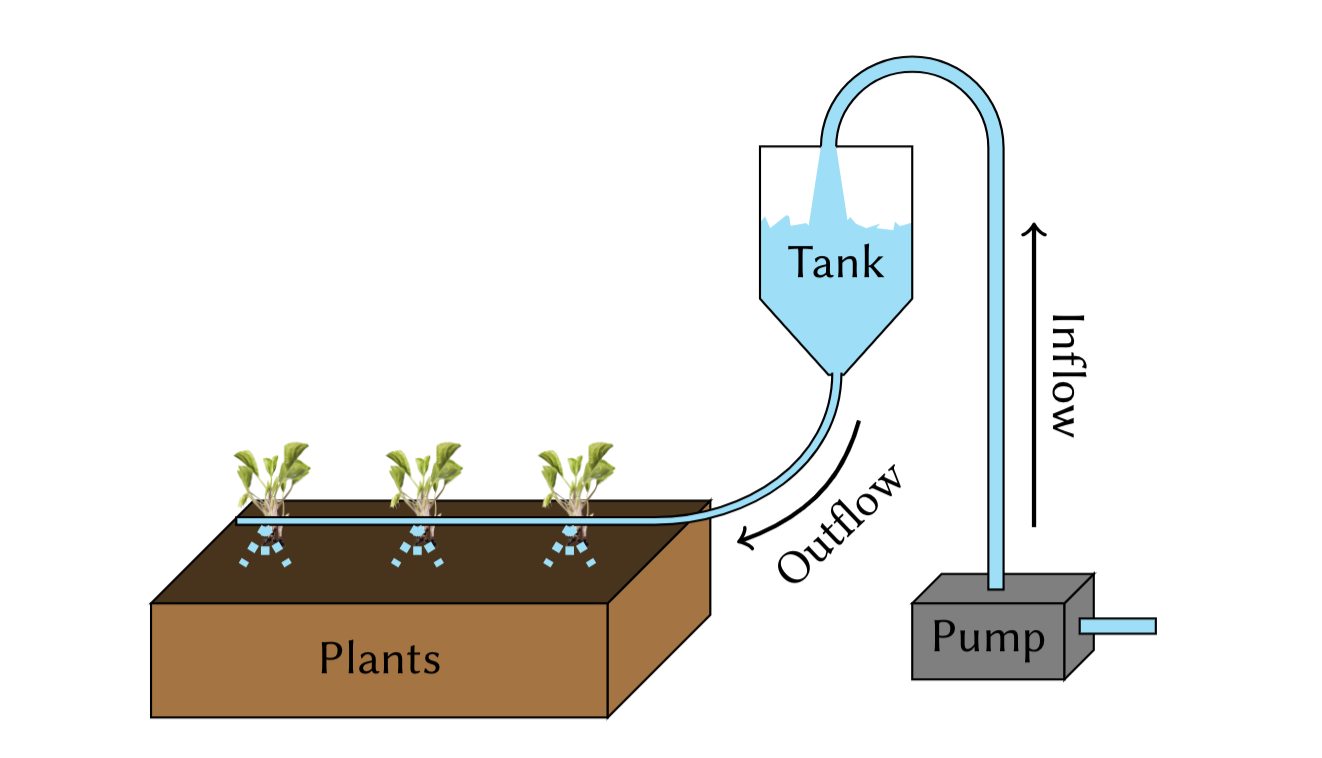

At regular intervals a relay activates a small water pump that fills the reservoir. 
The flow rate of the water pump varies depending on the pumping height, and is generally also unknown.
Additionally, the filling of the water tank can be slightly delayed due to the length of the inflow hose.

The purpose of our research is to create a model of the two watering subsystems and assert that there is no overflow of the water reservoirs.
Hence, it is necessary to calibrate the model according to the actual in- and outflow rates. 
As the values are unknown, we will apply machine learning techniques based on sample measurements to discover these parameters.


## Detection of the water volume in an image
To be able to detect the volume of water present inside the tanks of the system at any given time, the function mapping the water level in a tank to the volume it contains needs to be learned. This is done as follows.

First, pictures of the system with volumes of water varying from 0.0 to 1.45 litres in steps of 0.05L are taken. For each volume, 3 different images are captured. Below, samples of the photos taken during this phase are shown.

Populating the interactive namespace from numpy and matplotlib


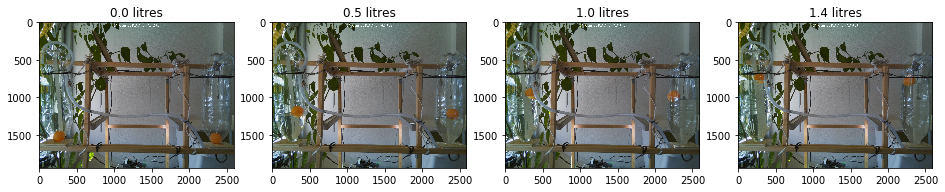

In [15]:
import os
import imageio  # read images into numpy arrays
import matplotlib.pyplot as plt  # plotting of images

# The images are loaded.
imgs = []
for img in os.listdir('files/volumes'):
    if img.endswith('.jpg'):
        imgs.append((float('.'.join(img.split('.')[0:2])),
                     imageio.imread(os.path.join('files/volumes', img))))

names, images = zip(*sorted(imgs))

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 5)

# They are plotted in ascending order of volume.
fig = plt.figure()
for i in range(4):
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(images[i])
    ax.set_title(str(names[i])+' litres')

The water level in the photos is then detected with the help of the image recognition algorithm presented in the [*ImageRecognition*](ImageRecognition.ipynb) notebook. The example for the right tank is illustrated below.

The image recognition functionality was bundled into the [`utils` library](utils.py), which will be used in the rest of this section.

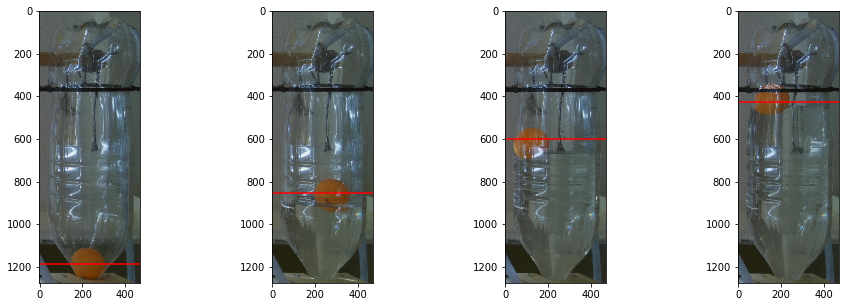

In [16]:
from utils import crop_image, detect_ball

# The images are first cropped.
# The cropping coordinates for the right tank are defined.
right_crop = dict(topleft=(365, 2120), bottomright=(1640, 2592))

fig = plt.figure()
for i, image in enumerate(images):
    # Each image is cropped.
    cropped_image = crop_image(image, right_crop['topleft'], right_crop['bottomright'])
    # The ball is detected.
    (_, ball_y) = detect_ball(cropped_image, 80)
    # The height of the ball is plotted.
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(cropped_image)
    ax.axhline(y=ball_y, color='r')

The average water level between the three images captured for each volume is computed. Since the amount of water is known in every image, a trace of the volume given the average water level (or ball height) can be produced. A polynomial regression on this trace creates a function approximation that maps the water level (ball height) to the volume.

Text(0.5,1,"Water volume in the right tank given the ball's height")

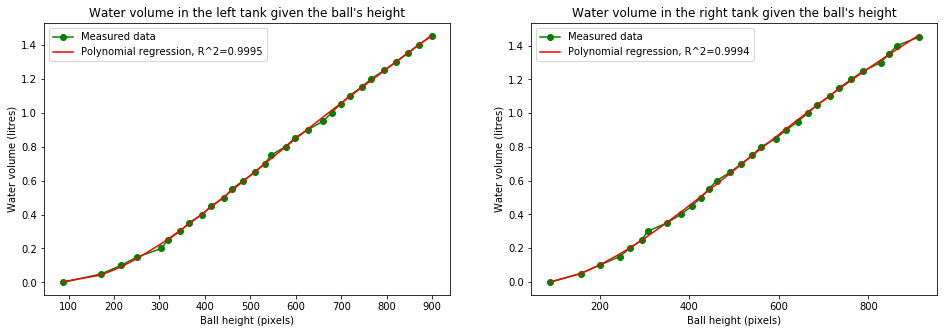

In [17]:
from utils import load_data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

    
# The traces of the water volume given the ball height for the left and right tank
# are loaded.
x_left, y_left = load_data('files/height_volume_left.csv')
x_right, y_right = load_data('files/height_volume_right.csv')

# Polynomial regressions of degree 4 are fit on the traces.
poly = PolynomialFeatures(degree=4)
x_poly_left = poly.fit_transform(x_left)
x_poly_right = poly.fit_transform(x_right)
reg_left = LinearRegression()
reg_left.fit(x_poly_left, y_left)
y_pred_left = reg_left.predict(x_poly_left)
r2_left = r2_score(y_left, y_pred_left)

reg_right = LinearRegression()
reg_right.fit(x_poly_right, y_right)
y_pred_right = reg_right.predict(x_poly_right)
r2_right = r2_score(y_right, y_pred_right)

# The results are plotted.
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.plot(x_left, y_left, '-og')
ax1.plot(x_left, y_pred_left, '-r')
ax1.legend(["Measured data",
            "Polynomial regression, R^2={:.4f}".format(r2_left)])
ax1.set_title("Water volume in the left tank given the ball's height")
ax1.set_xlabel('Ball height (pixels)')
ax1.set_ylabel('Water volume (litres)')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(x_right, y_right, '-og')
ax2.plot(x_right, y_pred_right, '-r')
ax2.legend(["Measured data",
            "Polynomial regression, R^2={:.4f}".format(r2_right)])
ax2.set_xlabel('Ball height (pixels)')
ax2.set_ylabel('Water volume (litres)')
ax2.set_title("Water volume in the right tank given the ball's height")

When a photo of the system is taken, the volume present in its tanks can be estimated by first detecting the balls' heights and then using the regression functions to map the height to the volume. This way, we are able to automatically detect water volumes that were not manually calibrated. An example is presented below.

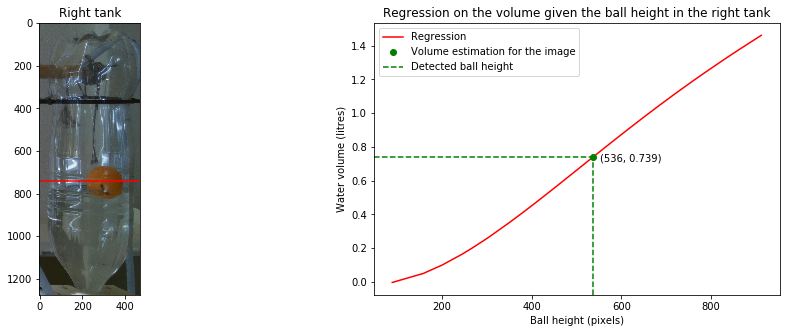

Volume of water in the right tank: 0.74 litres


In [18]:
from utils import get_ball_height

# An image with unknown water volumes in the tanks is loaded.
image = imageio.imread('files/system_image.jpg')

# The ball's height in the right tank is detected.
ball_height = get_ball_height(image, 80, right_crop['topleft'], right_crop['bottomright'])

# The regression for the right tank is used to determine the amount of water present in the image.
height_poly = poly.fit_transform(ball_height)
volume = reg_right.predict(height_poly)

# The results are plotted, along with a visualisation of the process to detect the water level
# in an image.
cropped_image = crop_image(image, right_crop['topleft'], right_crop['bottomright'])
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(cropped_image)
ax1.axhline(y=cropped_image.shape[0]-ball_height, color='r')
ax1.set_title('Right tank')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(x_right, y_pred_right, '-r')
xmin, xmax, ymin, ymax = ax2.axis()
ax2.plot(ball_height, volume, 'og')
ax2.axhline(y=volume, xmin=0, xmax=(ball_height-xmin)/(xmax-xmin), color='g', linestyle="dashed")
ax2.axvline(x=ball_height, ymin=0, ymax=(volume-ymin)/(ymax-ymin), color='g', linestyle="dashed")
ax2.annotate(f"({ball_height}, {volume[0][0]:{2}.{3}})", xy=(ball_height, volume), xytext=(ball_height+15, volume-0.025))

ax2.set_title('Regression on the volume given the ball height in the right tank')
ax2.legend(['Regression', 'Volume estimation for the image', 'Detected ball height'])
plt.xlabel('Ball height (pixels)')
plt.ylabel('Water volume (litres)')
plt.show()

print("Volume of water in the right tank: {:.2f} litres".format(volume[0][0]))

## Extracting the water flow rates

### Volume/time traces
To be able to compute the volumetric flow rates of the two tanks in the system, the function describing the evolution of the water volume in the tanks over time needs to be learned. This is done by taking pictures of the system at regular intervals (e.g. every two seconds) while the tanks are filled by the pumps and emptied on the plants. The volume of water in each image is then detected with the method described above. Since the time at which each image was captured is known, a trace of the volume over time can be produced for each water tank.

To increase the performance of this notebook, we pre-calculated the values that were extracted for the images.
The data is provided in two .csv files for the [left](files/time_volume_left.csv) and [right](files/time_volume_right.csv) tanks.

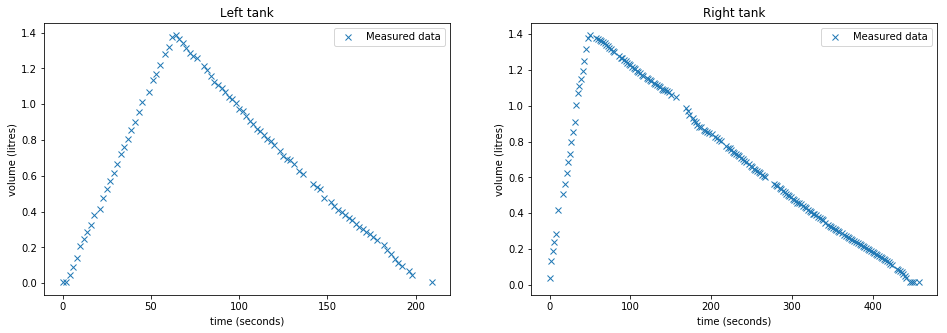

In [19]:
# The traces of the water volume over time for the left and right tank
# are loaded.
xflow_left, yflow_left = load_data('files/time_volume_left.csv')
xflow_right, yflow_right = load_data('files/time_volume_right.csv')

# They are plotted.
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.plot(xflow_left, yflow_left, 'x')
ax1.set_title("Left tank")
ax1.set_xlabel('time (seconds)')
ax1.set_ylabel('volume (litres)')
ax1.legend(['Measured data'])
ax2 = fig.add_subplot(1,2,2)
ax2.plot(xflow_right, yflow_right, 'x')
ax2.set_title("Right tank")
ax2.set_xlabel('time (seconds)')
ax2.set_ylabel('volume (litres)')
ax2.legend(['Measured data'])

### Regression on the traces
The functions describing the evolution of the water volume over time when the tanks are filled and emptied are approximated with regressions applied on the volume/time traces.

First, the traces are split in two separate sets of points: one for the filling phase (which will allow us to estimate the incoming flow rate), and one for the emptying phase (for the outgoing flow rate). Splitting is performed at the point where the volume is maximum in each tank, since this point is reached when the pumps are stopped and the filling phase is interrupted.

In [20]:
# The point where the volume is maximum gives us the time at which
# the pump stopped sending water to the tank.
splitting_left = np.argmax(yflow_left)
splitting_right = np.argmax(yflow_right)

# The inflow function will be computed for points where the volume increases over time.
inflow_x_left, inflow_y_left = xflow_left[0:splitting_left+1], yflow_left[0:splitting_left+1]
inflow_x_right, inflow_y_right = xflow_right[0:splitting_right+1], yflow_right[0:splitting_right+1]

# The outflow function where the volume decreases.
outflow_x_left, outflow_y_left = xflow_left[splitting_left+1:], yflow_left[splitting_left+1:]
outflow_x_right, outflow_y_right = xflow_right[splitting_right+1:], yflow_right[splitting_right+1:]

Once the traces are split, two regressions can be applied on each half to approximate the volume/time functions for the in- and outflow. For the inflow, we see on the traces that the corresponding function appears to be linear. A linear regression is hence applied.

In [21]:
from sklearn.linear_model import LinearRegression

inflow_left = LinearRegression()
inflow_left.fit(inflow_x_left, inflow_y_left)

inflow_right = LinearRegression()
inflow_right.fit(inflow_x_right, inflow_y_right)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

For the outflow, we observe on the traces that the corresponding function doesn't seem to follow a linear behaviour. A piecewise linear regression is hence applied. We also apply a simple linear regression for comparison. 

In [22]:
import pwlf

# Piecewise linear regressions are applied on the outflow for the two tanks.
outflow_left = pwlf.PiecewiseLinFit(outflow_x_left[:, 0], outflow_y_left[:, 0])
outflow_right = pwlf.PiecewiseLinFit(outflow_x_right[:, 0], outflow_y_right[:, 0])

# An arbitrary number of 3 intervals is used for the fitting.
intervals_left = outflow_left.fit(3)
intervals_right = outflow_right.fit(3)

# Linear regressions are also applied for comparison.
lin_outflow_left = LinearRegression()
lin_outflow_right = LinearRegression()
lin_outflow_left.fit(outflow_x_left, outflow_y_left)
lin_outflow_right.fit(outflow_x_right, outflow_y_right)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We plot the regressions below with their associated coefficients of determination (R^2 values). We can see on the plots that the piecewise linear regression performs better than the simple linear regression on the outflows.

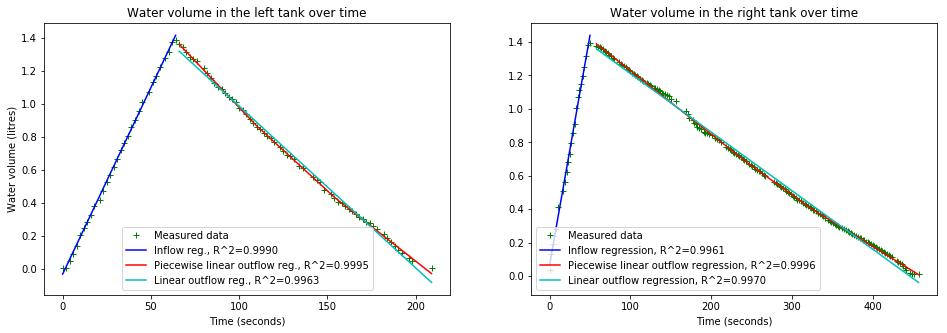

In [23]:
from sklearn.metrics import r2_score

# The regressions are applied on the data points.
inflow_pred_left = inflow_left.predict(inflow_x_left)
inflow_pred_right = inflow_right.predict(inflow_x_right)

outflow_pred_left = outflow_left.predict(outflow_x_left[:, 0])
outflow_pred_right = outflow_right.predict(outflow_x_right[:, 0])

lin_out_pred_left = lin_outflow_left.predict(outflow_x_left)
lin_out_pred_right = lin_outflow_right.predict(outflow_x_right)

# The R^2 scores are computed.
r2_inflow_left = r2_score(inflow_y_left, inflow_pred_left)
r2_inflow_right = r2_score(inflow_y_right, inflow_pred_right)

r2_outflow_left = r2_score(outflow_y_left, outflow_pred_left)
r2_outflow_right = r2_score(outflow_y_right, outflow_pred_right)

r2_lin_out_left = r2_score(outflow_y_left, lin_out_pred_left)
r2_lin_out_right = r2_score(outflow_y_right, lin_out_pred_right)

# The regressions and their scores are plotted.
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(xflow_left, yflow_left, '+g')
ax1.plot(inflow_x_left, inflow_pred_left, '-b')
ax1.plot(outflow_x_left, outflow_pred_left, '-r')
ax1.plot(outflow_x_left, lin_out_pred_left, '-c')
plt.xlabel('Time (seconds)')
plt.ylabel('Water volume (litres)')
ax1.set_title("Water volume in the left tank over time")
ax1.legend(["Measured data",
            "Inflow reg., R^2={:.4f}".format(r2_inflow_left),
            "Piecewise linear outflow reg., R^2={:.4f}"
            .format(r2_outflow_left),
            "Linear outflow reg., R^2={:.4f}"
            .format(r2_lin_out_left)])

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(xflow_right, yflow_right, '+g')
ax2.plot(inflow_x_right, inflow_pred_right, '-b')
ax2.plot(outflow_x_right, outflow_pred_right, '-r')
ax2.plot(outflow_x_right, lin_out_pred_right, '-c')
plt.xlabel('Time (seconds)')
ax2.set_title("Water volume in the right tank over time")
ax2.legend(["Measured data",
            "Inflow regression, R^2={:.4f}".format(r2_inflow_right),
            "Piecewise linear outflow regression, R^2={:.4f}"
            .format(r2_outflow_right),
            "Linear outflow regression, R^2={:.4f}"
            .format(r2_lin_out_right)])

### Estimation of the flow rates
The volumetric flow rate is defined as the first derivative of the function describing the volume passing through some surface over time. Hence, once the volume/time functions of the two tanks have been learned as shown above, their incoming and outgoing flow rates can be determined by taking the slopes of the learned functions.

In [24]:
print("Estimated inflow for the left tank: {:.6f} l/s\n".format(inflow_left.coef_[0][0]))
print("Estimated inflow for the right tank: {:.6f} l/s\n".format(inflow_right.coef_[0][0]))

print("Estimated outflow for the left tank: ")
for i in range(3):
    vi = outflow_left.predict([intervals_left[i]])
    vi1 = outflow_left.predict([intervals_left[i+1]])
    print("\t{:.6f} l/s from {:.3f}L to {:.3f}L, "
          .format(outflow_left.slopes[i], vi[0], vi1[0]))

print("\nEstimated outflow for the right tank: ")
for i in range(3):
    vi = outflow_right.predict([intervals_right[i]])
    vi1 = outflow_right.predict([intervals_right[i+1]])
    print("\t{:.6f} l/s from {:.3f}L to {:.3f}L, "
          .format(outflow_right.slopes[i], vi[0], vi1[0]))

Estimated inflow for the left tank: 0.022628 l/s

Estimated inflow for the right tank: 0.027432 l/s

Estimated outflow for the left tank: 
	-0.011287 l/s from 1.363L to 0.869L, 
	-0.009827 l/s from 0.869L to 0.426L, 
	-0.008401 l/s from 0.426L to -0.029L, 

Estimated outflow for the right tank: 
	-0.003800 l/s from 1.388L to 0.676L, 
	-0.003467 l/s from 0.676L to 0.407L, 
	-0.002973 l/s from 0.407L to 0.009L, 


### Validation of the results
Once the regressions have been applied on the training data and the flow rates have been computed, we apply the results on test sets and compute their coefficients of determination in order to validate our approach.

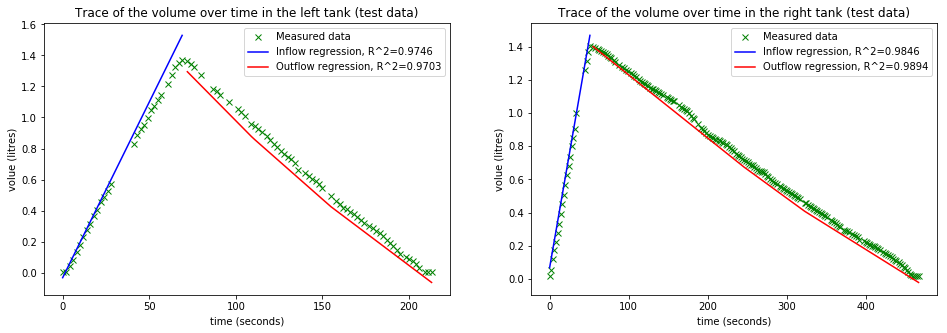

In [25]:
# Test traces for the volume/time in the left and right tank are loaded.
x_test_left, y_test_left = load_data('files/time_volume_test_left.csv')
x_test_right, y_test_right = load_data('files/time_volume_test_right.csv')

# The traces are split in two in a similar way as the training data.
split_index_left = np.argmax(y_test_left)
split_index_right = np.argmax(y_test_right)

x_test_in_left = x_test_left[:split_index_left+1]
y_test_in_left = y_test_left[:split_index_left+1]
x_test_out_left = x_test_left[split_index_left+1:]
y_test_out_left = y_test_left[split_index_left+1:]

x_test_in_right = x_test_right[:split_index_right+1]
y_test_in_right = y_test_right[:split_index_right+1]
x_test_out_right = x_test_right[split_index_right+1:]
y_test_out_right = y_test_right[split_index_right+1:]

# The regressions are applied on the traces.
in_pred_left = inflow_left.predict(x_test_in_left)
out_pred_left = outflow_left.predict(x_test_out_left[:, 0])

in_pred_right = inflow_right.predict(x_test_in_right)
out_pred_right = outflow_right.predict(x_test_out_right[:, 0])

# Their scores are computed.
r2_in_left = r2_score(y_test_in_left, in_pred_left)
r2_out_left = r2_score(y_test_out_left, out_pred_left)

r2_in_right = r2_score(y_test_in_right, in_pred_right)
r2_out_right = r2_score(y_test_out_right, out_pred_right)

# The results are plotted.
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(x_test_left, y_test_left, 'xg')
ax1.plot(x_test_in_left, in_pred_left, '-b')
ax1.plot(x_test_out_left, out_pred_left, '-r')
ax1.set_xlabel('time (seconds)')
ax1.set_ylabel('volue (litres)')
ax1.set_title('Trace of the volume over time in the left tank (test data)')
ax1.legend(['Measured data',
           'Inflow regression, R^2={:.4f}'.format(r2_in_left),
           'Outflow regression, R^2={:.4f}'.format(r2_out_left)])

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(x_test_right, y_test_right, 'xg')
ax2.plot(x_test_in_right, in_pred_right, '-b')
ax2.plot(x_test_out_right, out_pred_right, '-r')
ax2.set_xlabel('time (seconds)')
ax2.set_ylabel('volue (litres)')
ax2.set_title('Trace of the volume over time in the right tank (test data)')
ax2.legend(['Measured data',
           'Inflow regression, R^2={:.4f}'.format(r2_in_right),
           'Outflow regression, R^2={:.4f}'.format(r2_out_right)])

## Testing the system
Once the flow rates have been computed, the results are tested on a specific use case. The water pump of one of the tanks (in this case the right one) is run for 10 seconds and then stopped for 30. The process is repeated three times in a row. While the tank is filled and emptied, pictures of the system are automatically captured. They are then analysed in order to extract the water volume at each timestep, producing the following trace. 

Text(0.5,1,'Trace of the volume over time during the testing process')

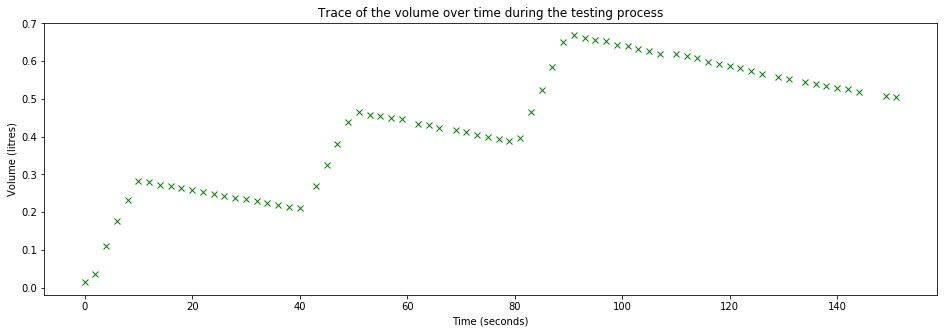

In [26]:
x_test, y_test = load_data('files/time_volume_test.csv')

plt.plot(x_test, y_test, 'xg')
plt.xlabel('Time (seconds)')
plt.ylabel('Volume (litres)')
plt.title('Trace of the volume over time during the testing process')

We apply the in- and outflow computed in the previous section on the trace and compare it to the measured data. 

R^2 score of the predictions: 0.9815


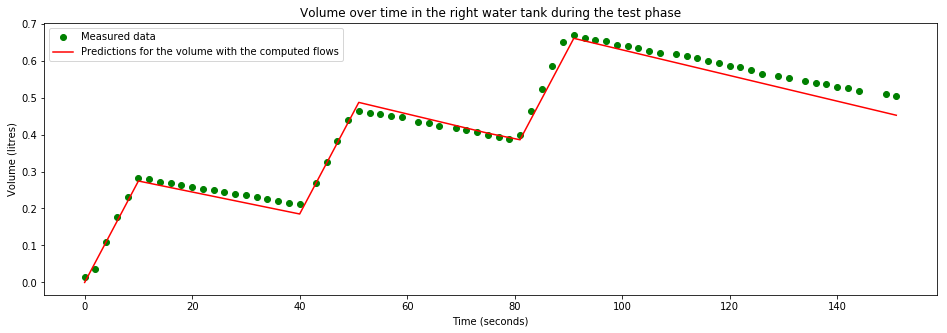

In [27]:
# The test data is transformed into Python lists for simpler manipulation.
test_times = [x[0] for x in x_test]
test_volumes = [y[0] for y in y_test]

# The intervals where the tank is filled and emptied are determined.
start_stop_times = [10, 40, 50, 80, 90]
breaks = [0]
for t in start_stop_times:
    closest = min(test_times, key=lambda x:abs(x-t))
    breaks.append(test_times.index(closest))
    if closest < t:
        breaks[-1] += 1
breaks.append(len(test_times)-1)

# The measured data is plotted for comparison with the previsions of our system.
plt.plot(test_times, test_volumes, 'og')
plt.xlabel('Time (seconds)')
plt.ylabel('Volume (litres)')
plt.title('Volume over time in the right water tank during the test phase')

# The predictions of the volume over time with the learned flow rates are computed.
init_volume = 0
predictions = [init_volume]
for i in range(len(breaks)-1):
    times = test_times[breaks[i]:breaks[i+1]+1]
    volumes = test_volumes[breaks[i]:breaks[i+1]+1]
    
    last_volume = init_volume
    relative_times = times - times[0]
    
    # The inflow is applied on the first, third and fifth interval of data points.
    if i % 2 == 0:
        for t in relative_times[1:]:
            predictions.append(last_volume + inflow_right.coef_[0][0]*t)
    # The outflow is applied on the second, fourth and last interval.
    else:
        volume = last_volume
        for j, t in enumerate(relative_times[1:]):
            # The outflow rate for the current volume is determined at each step of the
            # outflow computation to adapt to the learned model.
            outflow_interval = 0
            if volume < outflow_right.predict([intervals_right[1]]):
                outflow_interval = 1
            if volume < outflow_right.predict([intervals_right[2]]):
                outflow_interval = 2
            
            # The new volume of water at each timestep is computed.
            volume = volume + outflow_right.slopes[outflow_interval]*(t-relative_times[j])
            predictions.append(volume)
        
    init_volume = predictions[-1]
    
plt.plot(test_times, predictions, '-r')
plt.legend(['Measured data', 'Predictions for the volume with the computed flows'])

print("R^2 score of the predictions: {:.4f}".format(r2_score(test_volumes, predictions)))